# Gaussian Mixture Models from Scratch

A Gaussian Mixture Model is a probabilistic clustering method that assumes the data is generated from a mixture of several Gaussian distributions.

Instead of assigning each point to a single cluster (like k-means), in GMMs each point belongs to clusters with certain probabilities.


#### Pros:

- Flexible cluster shapes. Clusters can be elliptical and oriented in any direction

- Soft clustering via probabilities


#### Cons:

- Assumes Gaussian-shaped components

- Requires specifying the number of components

- Struggles with clusters of very different sizes or densities

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

(650, 2)


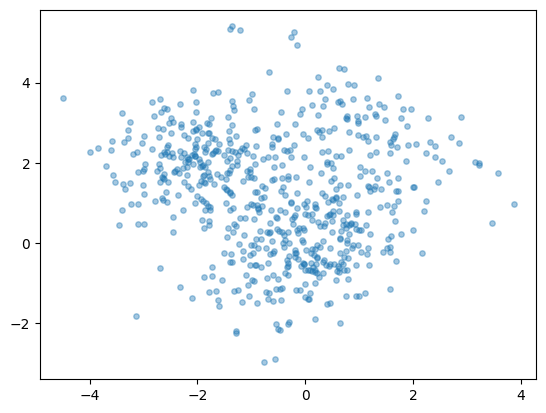

In [22]:
np.random.seed(42)

mu1_real, mu2_real, mu3_real = [0, 0], [1, 3], [-2, 2]
cov1_real, cov2_real, cov3_real = [[1, 0.3], [0.3, 1]], [[1, -0.7], [-0.7, 1]], [[1, 0], [0, 0.5]] 

data = np.vstack([
    np.random.multivariate_normal(mu1_real, cov1_real, 300),
    np.random.multivariate_normal(mu2_real, cov2_real, 100),
    np.random.multivariate_normal(mu3_real, cov3_real, 250)
])

X = np.array(data)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1], s=15, alpha=0.4)
plt.show()

### Expectation Maximization (EM)

To cluster the data, a GMM uses the Expectation Maximization (EM) algorithm.
EM adjusts a set of Gaussian distributions so they best fit the data.

E-step:

- Given the current Gaussians, we compute how likely each point is to belong to each component.
These probabilities are called responsibilities.

M-step:

- Using those responsibilities, we update the means, the covariances, and the mixture weights. Each update is just a weighted average of the data.

Repeat

- E-step and M-step alternate until the Gaussians stop changing.


In [55]:
np.random.seed(42)

N, d = X.shape # N = n datapoints, d = data variables
K = 3 # n clusters

# initialize parameters pi, mu and Sigma
pi = np.ones(K) / K
mu = X[np.random.choice(N, K, replace=False)]
Sigma = [np.eye(d) for _ in range(K)]


for iter in range(100):
    # E-step:
    # pdfs: for each datapoint, compute likelihood that it belongs to each class
    pdfs = np.array([
        pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])
        for k in range(K)
    ]).T # shape N, K

    responsibilities = pdfs / (pdfs.sum(axis=1, keepdims=True)) # normalized to get responsibilities, shape N, K

    # M-step: update parameters
    N_k = responsibilities.sum(axis=0) # estimate of number of datapoints per class, shape K,
    pi = N_k / N
    mu = (responsibilities.T @ X) / N_k[:, np.newaxis] # shape K, d

    Sigma = []
    for k in range(K):
        diff = X - mu[k]
        cov = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
        Sigma.append(cov)


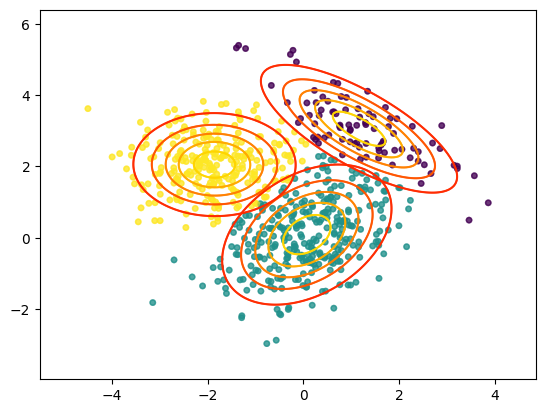

In [71]:
x = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 200)
y = np.linspace(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, 200)
Xgrid, Ygrid = np.meshgrid(x, y)

for i in range(K):
    rv = multivariate_normal(mu[i], Sigma[i])
    Z = rv.pdf(np.dstack((Xgrid, Ygrid)))
    plt.contour(Xgrid, Ygrid, Z, levels=5, cmap="autumn", alpha=0.9)

    plt.contour(
        Xgrid, Ygrid, Z,
        levels=5,
        linewidths=1.2,
        cmap="autumn",
        alpha=0.9
    )
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(responsibilities, axis=1), s=15, alpha=0.4)

plt.show()

This can be implemented using the sklearn library as follows:

In [69]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=3,       # number of Gaussians
    covariance_type="full",  # full covariance → flexible shapes
    random_state=0
)

gmm.fit(X)
labels = gmm.predict(X)        # hard cluster assignments
probs = gmm.predict_proba(X)   # soft probabilities

print(probs[:5])

[[1.27754753e-04 1.56390326e-03 9.98308342e-01]
 [3.59393062e-04 3.51180761e-01 6.48459846e-01]
 [3.64915887e-03 1.99611220e-03 9.94354729e-01]
 [1.05991845e-06 7.37593301e-03 9.92623007e-01]
 [1.83348374e-02 2.75157813e-02 9.54149381e-01]]


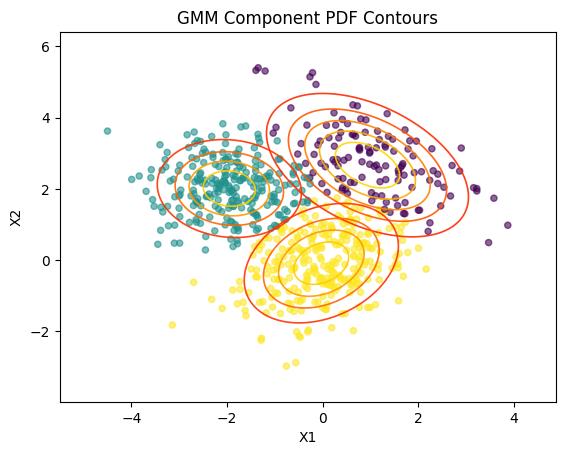

In [70]:
def plot_gmm_pdf_contours(gmm, X, labels, ax=None, levels=5):

    ax = ax or plt.gca()

    # Scatter the actual data
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap="viridis", alpha=0.6)

    # Build a grid over the data
    x = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 200)
    y = np.linspace(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, 200)
    Xgrid, Ygrid = np.meshgrid(x, y)
    grid_points = np.column_stack([Xgrid.ravel(), Ygrid.ravel()])

    # For each Gaussian component, plot its PDF contour
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        cov = gmm.covariances_[i]

        rv = multivariate_normal(mean, cov)
        Z = rv.pdf(grid_points).reshape(Xgrid.shape)

        ax.contour(
            Xgrid, Ygrid, Z,
            levels=levels,
            linewidths=1.2,
            cmap="autumn",
            alpha=0.9
        )

    ax.set_title("GMM Component PDF Contours")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

plot_gmm_pdf_contours(gmm, X, labels, levels=5)
plt.show()